# UTS IBDA 3311 / Deep Learning

In [1]:
import numpy as np
import copy
from utils import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn.model_selection import train_test_split
import scipy
import cv2
import glob
from PIL import Image
import matplotlib.pyplot as plt
import os
import random

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
mask_list = glob.glob('/data/*/*.jpg')

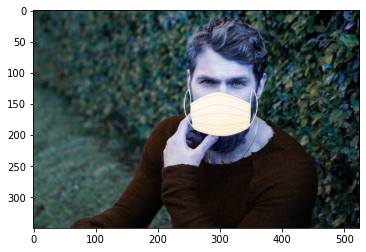

In [3]:
img1 = cv2.imread('data/with_mask/with_mask_1.jpg')
data = np.array(img1)
plt.imshow(data)
plt.show()

### Menampilkan contoh gambar

In [4]:
DATADIR = "data" # direktori dari gambar with_mask dan without_mask
CATEGORIES = ['without_mask', 'with_mask'] # label untuk gambar with_mask dan without_mask dari folder data
def load_data(directory, categories):
    with_mask = []
    without_mask = []

    for category in categories:
        path = os.path.join(directory, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                img_array = cv2.resize(img_array, (64,64))
                if(class_num == 0):
                    without_mask.append((img_array, class_num))
                else:
                    with_mask.append((img_array, class_num))
            except:
                pass
                
    with_mask = np.asarray(with_mask)
    without_mask = np.asarray(without_mask)
    
    train_dataset = np.concatenate((with_mask[:int(len(with_mask)/2)+1], without_mask[:int(len(without_mask)/2)+1]))
    val_dataset = np.concatenate((with_mask[int(len(with_mask)/2)+1:], without_mask[int(len(without_mask)/2)+1:]))
    
    train_images = []
    train_labels = []
    for i in train_dataset:
        train_images.append(i[0])
        train_labels.append(i[1])
        
    val_images = []
    val_labels = []
    for i in val_dataset:
        val_images.append(i[0])
        val_labels.append(i[1])
    
    
    train_images = np.asarray(train_images)
    train_labels = np.asarray(train_labels)
    val_images = np.asarray(val_images)
    val_labels = np.asarray(val_labels)
    
    
    return train_images, train_labels, val_images, val_labels

In [5]:
train_images, train_labels, val_images, val_labels = load_data(DATADIR, CATEGORIES)

c:\python\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [6]:
#Menentukan data latih dan data uji
train_set_x_orig, test_set_x_orig, train_set_y, test_set_y = train_test_split(train_images, train_labels, test_size = 0.3, random_state=42)

In [7]:
m_train = train_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
m_test = test_set_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_set_x_orig.shape))
print ("train_y shape: " + str(train_set_y.shape))
print ("test_x_orig shape: " + str(test_set_x_orig.shape))
print ("test_y shape: " + str(test_set_y.shape))

Number of training examples: 2644
Number of testing examples: 1134
Each image is of size: (64, 64, 3)
train_x_orig shape: (2644, 64, 64, 3)
train_y shape: (2644,)
test_x_orig shape: (1134, 64, 64, 3)
test_y shape: (1134,)


In [192]:
# Melakukan reshape untuk data latih dan data uji
train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

#Memanggil data latih dan data uji yang telah di flatten dan menampilkan shape dari data tersebut.
print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 2644)
test_x's shape: (12288, 1134)


## Model Architecture

## L layer model

In [193]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 5,5,6
n_y = 1
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.005

In [194]:
# Membuat initialize parameter
def initialize_parameters(n_x, n_h, n_y):
    W1 = np.random.randn(n_h,n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_h, n_y)*0.01
    b2 = np.zeros((n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [195]:
# Membuat linear propagation forward
def linear_forward(A_prev, W, b):
    Z = np.dot(W, A_prev) + b
    cache = (A_prev, W, b)
    return Z, cache


def linear_activation_forward(A_prev, W, b, activation):
    if activation== "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    elif activation == "tanh":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = tanh(Z)

    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    assert A.shape == (W.shape[0], A_prev.shape[1])

    cache = (linear_cache, activation_cache)
    return A, cache

In [196]:
# Menghitung nilai cost function

def compute_cost(A2, Y):
    m = Y.shape[0]
    cost = (-1 / m) * np.sum(Y * np.log(A2) + (1 - Y) * np.log(1 - A2), axis = 1)
    return cost

In [197]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ, A_prev.T)
    db = (1/m)*np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

In [198]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters)//2
    
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]
    
    return parameters

In [200]:
### CONSTANTS ###
layers_dims = [12288, 10, 7, 6, 1] #  4-layer model

In [201]:
# Melakukan inisialisasi parameter untuk model l layer model
def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
    
    return parameters

In [202]:
# Function untuk mengetahui nilai dari L_model_forward
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2 
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W'+str(l)], parameters['b'+str(l)], activation = "relu")
        caches.append(cache)
    AL, cache = linear_activation_forward(A, parameters['W'+str(L)], parameters['b'+str(L)], activation = "sigmoid")
    caches.append(cache)
    assert(AL.shape == (1,X.shape[1]))
    return AL, caches

In [203]:
#Melakukan penghitungan cost dengan parameter AL, Y
def compute_cost(AL, Y):
    m = Y.reshape([1,len(Y)]).shape[1]
    cost = (-1 / m) * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL), axis = 1)
    return cost

In [204]:
# Melakukan penghitungan L_model_backward dengan parameter AL, Y, caches
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA"+str(l+1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

In [205]:
# Melakukan update parameter
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # Membagi panjang dari parameter menjadi 2 untuk W dan b
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l + 1)]
    return parameters

In [206]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.005, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(2)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    #(≈ 1 line of code)
    # parameters = ...
    # YOUR CODE STARTS HERE
    parameters = initialize_parameters_deep(layers_dims)
    
    # YOUR CODE ENDS HERE
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        #(≈ 1 line of code)
        # AL, caches = ...
        # YOUR CODE STARTS HERE
        AL, caches = L_model_forward(X, parameters)
        # YOUR CODE ENDS HERE
        # Compute cost.
        #(≈ 1 line of code)
        # cost = ...
        # YOUR CODE STARTS HERE
        cost = compute_cost(AL,Y)
        # YOUR CODE ENDS HERE
    
        # Backward propagation.
        #(≈ 1 line of code)
        # grads = ...    
        # YOUR CODE STARTS HERE
        grads = L_model_backward(AL, Y, caches)
        # YOUR CODE ENDS HERE
 
        # Update parameters.
        #(≈ 1 line of code)
        # parameters = ...
        # YOUR CODE STARTS HERE
        parameters = update_parameters(parameters,grads,learning_rate)
        
        # YOUR CODE ENDS HERE
                
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

In [207]:
parameters, costs = L_layer_model(train_x, train_set_y, layers_dims, num_iterations = 500, print_cost = True)

Cost after iteration 0: 0.6931471702505961
Cost after iteration 100: 0.6930695910600997
Cost after iteration 200: 0.6930091837435873
Cost after iteration 300: 0.6929621421546179
Cost after iteration 400: 0.6929255067092446
Cost after iteration 499: 0.6928972361962398


In [208]:
def predict(parameters, X):
    AL, cache = L_model_forward(X, parameters)
    predictions = (AL > 0.5)
    return predictions

def accuracy(predictions, y):
    acc = float((np.dot(y, predictions.T) + np.dot(1 - y, 1 - predictions.T)) / float(y.size) * 100)
    return acc

In [209]:
prediction = predict(parameters, train_x)
print(accuracy(prediction, train_set_y))

51.32375189107413


In [210]:
prediction = predict(parameters, test_x)
print(accuracy(prediction, test_set_y))

49.2063492063492


In [211]:
def predict_pict(parameters, X):
    AL, cache = L_model_forward(X, parameters)
    if AL > 0.5:
        predictions = 1
    else:
        predictions = 0
    return predictions

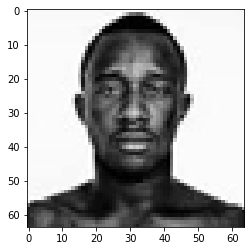

y = 0


In [212]:
## START CODE HERE ##
my_image = "without_mask_1.jpg" # change this to the name of your image file 
my_label_y = [0] # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

fname = "data/" + my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
plt.show()
image = image // 255
image = image.reshape((1, num_px * num_px * 3))
my_predicted_image = predict_pict(parameters,image.T)

print ("y = " + str(np.squeeze(my_predicted_image)))